# **This baseline provide a ensemble plan can help you get higher score!**
The class2 ensemble plan used ten B7 models，two B5 model, two resNet152V2 and resNet101 models. The key is B7 models and resNet models

[There is the efficientNet train](https://www.kaggle.com/jasonhuangcn/tf-with-efficientnet-train).

[There is the resNet train](https://www.kaggle.com/jasonhuangcn/tf-with-resnet101-train)

In [1]:
%load_ext autoreload
%autoreload 2

!conda install '/kaggle/input/pydicom-conda-helper/libjpeg-turbo-2.1.0-h7f98852_0.tar.bz2' -y --offline
!conda install '/kaggle/input/pydicom-conda-helper/libgcc-ng-9.3.0-h2828fa1_19.tar.bz2' -y --offline
!conda install '/kaggle/input/pydicom-conda-helper/gdcm-2.8.9-py37h500ead1_1.tar.bz2' -y --offline
!conda install '/kaggle/input/pydicom-conda-helper/conda-4.10.1-py37h89c1867_0.tar.bz2' -y --offline
!conda install '/kaggle/input/pydicom-conda-helper/certifi-2020.12.5-py37h89c1867_1.tar.bz2' -y --offline
!conda install '/kaggle/input/pydicom-conda-helper/openssl-1.1.1k-h7f98852_0.tar.bz2' -y --offline

!pip install '/kaggle/input/kerasapplications' --no-deps
!pip install '/kaggle/input/efficientnet-keras-source-code' --no-deps
!pip install '/kaggle/input/effdet-latestvinbigdata-wbf-fused/ensemble_boxes-1.0.4-py3-none-any.whl' --no-deps

## MMDetection compatible torch installation
!pip install '/kaggle/input/pytorch-170-cuda-toolkit-110221/torch-1.7.0+cu110-cp37-cp37m-linux_x86_64.whl' --no-deps
!pip install '/kaggle/input/pytorch-170-cuda-toolkit-110221/torchvision-0.8.1+cu110-cp37-cp37m-linux_x86_64.whl' --no-deps
!pip install '/kaggle/input/pytorch-170-cuda-toolkit-110221/torchaudio-0.7.0-cp37-cp37m-linux_x86_64.whl' --no-deps

## Compatible Cuda Toolkit installation
!mkdir -p /kaggle/tmp && cp /kaggle/input/pytorch-170-cuda-toolkit-110221/cudatoolkit-11.0.221-h6bb024c_0 /kaggle/tmp/cudatoolkit-11.0.221-h6bb024c_0.tar.bz2 && conda install /kaggle/tmp/cudatoolkit-11.0.221-h6bb024c_0.tar.bz2 -y --offline

## MMDetection Offline Installation
!pip install '/kaggle/input/mmdetectionv2140/addict-2.4.0-py3-none-any.whl' --no-deps
!pip install '/kaggle/input/mmdetectionv2140/yapf-0.31.0-py2.py3-none-any.whl' --no-deps
!pip install '/kaggle/input/mmdetectionv2140/terminal-0.4.0-py3-none-any.whl' --no-deps
!pip install '/kaggle/input/mmdetectionv2140/terminaltables-3.1.0-py3-none-any.whl' --no-deps
!pip install '/kaggle/input/mmdetectionv2140/mmcv_full-1_3_8-cu110-torch1_7_0/mmcv_full-1.3.8-cp37-cp37m-manylinux1_x86_64.whl' --no-deps
!pip install '/kaggle/input/mmdetectionv2140/pycocotools-2.0.2/pycocotools-2.0.2' --no-deps
!pip install '/kaggle/input/mmdetectionv2140/mmpycocotools-12.0.3/mmpycocotools-12.0.3' --no-deps

!cp -r /kaggle/input/mmdetectionv2140/mmdetection-2.14.0 /kaggle/working/
!mv /kaggle/working/mmdetection-2.14.0 /kaggle/working/mmdetection
%cd /kaggle/working/mmdetection
!pip install -e . --no-deps
%cd /kaggle/working/


######################################################################## | 100% 
Preparing transaction: - done
Verifying transaction: | done
Executing transaction: - \ done

######################################################################## | 100% 
Preparing transaction: - done
Verifying transaction: | done
Executing transaction: - \ | done

######################################################################## | 100% 
Preparing transaction: - done
Verifying transaction: | done
Executing transaction: - done

######################################################################## | 100% 
Preparing transaction: - done
Verifying transaction: | done
Executing transaction: - \ | / - \ | / - \ | / - \ | / - \ | / done

######################################################################## | 100% 
Preparing transaction: - done
Verifying transaction: | done
Executing transaction: - done

#####################

In [2]:
import sys
sys.path.append('/kaggle/working/mmdetection')

import os
from PIL import Image
import pandas as pd
from tqdm.auto import tqdm
import gc
import glob
import numpy as np

<span style="color: #00857e; font-family: Segoe UI; font-size: 1.8em; font-weight: 300;">Create Study and Image Level Dataframes</span>

In [3]:
sub_df = pd.read_csv('/kaggle/input/siim-covid19-detection/sample_submission.csv')

# Form study and image dataframes
sub_df['level'] = sub_df.id.map(lambda idx: idx[-5:])
study_df = sub_df[sub_df.level=='study'].rename({'id':'study_id'}, axis=1)
image_df = sub_df[sub_df.level=='image'].rename({'id':'image_id'}, axis=1)

dcm_path = glob.glob('/kaggle/input/siim-covid19-detection/test/**/*dcm', recursive=True)
test_meta = pd.DataFrame({'dcm_path':dcm_path})
test_meta['image_id'] = test_meta.dcm_path.map(lambda x: x.split('/')[-1].replace('.dcm', '')+'_image')
test_meta['study_id'] = test_meta.dcm_path.map(lambda x: x.split('/')[-3].replace('.dcm', '')+'_study')

study_df = study_df.merge(test_meta, on='study_id', how='left')
image_df = image_df.merge(test_meta, on='image_id', how='left')

# Remove duplicates study_ids from study_df
study_df.drop_duplicates(subset="study_id",keep='first', inplace=True)

<span style="color: #00857e; font-family: Segoe UI; font-size: 1.8em; font-weight: 300;">Fast or Full Predictions</span>

In case of non-competetion submission commits, we run the notebook with just two images each for image level and study level inference from the public test data.

In [4]:
fast_sub = False

if sub_df.shape[0] == 2477:
    fast_sub = True
    study_df = study_df.sample(2)
    image_df = image_df.sample(2)
    
    print("\nstudy_df")
    display(study_df.head(2))
    print("\nimage_df")
    display(image_df.head(2))
    print("\ntest_meta")
    display(test_meta.head(2))


study_df


,study_id,PredictionString,level,dcm_path,image_id
915,b378e3902756_study,negative 1 0 0 1 1,study,/kaggle/input/siim-covid19-detection/test/b378...,8d2c75ff8149_image
754,91fd1001ca08_study,negative 1 0 0 1 1,study,/kaggle/input/siim-covid19-detection/test/91fd...,2533fc9ec975_image



image_df


,image_id,PredictionString,level,dcm_path,study_id
450,da263425b379_image,none 1 0 0 1 1,image,/kaggle/input/siim-covid19-detection/test/3bc2...,3bc2eec8d9b6_study
618,59911e31f963_image,none 1 0 0 1 1,image,/kaggle/input/siim-covid19-detection/test/9b2f...,9b2f1505d1ba_study



test_meta


,dcm_path,image_id,study_id
0,/kaggle/input/siim-covid19-detection/test/2fb1...,a29c5a68b07b_image,2fb11712bc93_study
1,/kaggle/input/siim-covid19-detection/test/19c6...,9850b5470fd6_image,19c66935e737_study


In [5]:
import pydicom
from pydicom.pixel_data_handlers.util import apply_voi_lut

STUDY_DIMS = (768, 768)
IMAGE_DIMS = (512, 512)

study_dir = f'/kaggle/tmp/test/study/'
os.makedirs(study_dir, exist_ok=True)

image_dir = f'/kaggle/tmp/test/image/'
os.makedirs(image_dir, exist_ok=True)

def read_xray(path, voi_lut = True, fix_monochrome = True):
    # Original from: https://www.kaggle.com/raddar/convert-dicom-to-np-array-the-correct-way
    dicom = pydicom.read_file(path)
    
    # VOI LUT (if available by DICOM device) is used to transform raw DICOM data to 
    # "human-friendly" view
    if voi_lut:
        data = apply_voi_lut(dicom.pixel_array, dicom)
    else:
        data = dicom.pixel_array
               
    # depending on this value, X-ray may look inverted - fix that:
    if fix_monochrome and dicom.PhotometricInterpretation == "MONOCHROME1":
        data = np.amax(data) - data
        
    data = data - np.min(data)
    data = data / np.max(data)
    data = (data * 255).astype(np.uint8)
    return data

def resize(array, size, keep_ratio=False, resample=Image.LANCZOS):
    # Original from: https://www.kaggle.com/xhlulu/vinbigdata-process-and-resize-to-image
    im = Image.fromarray(array)
    
    if keep_ratio:
        im.thumbnail((size, size), resample)
    else:
        im = im.resize((size, size), resample)
    return im

for index, row in tqdm(study_df[['study_id', 'dcm_path']].iterrows(), total=study_df.shape[0]):
    # set keep_ratio=True to have original aspect ratio
    xray = read_xray(row['dcm_path'])
    im = resize(xray, size=STUDY_DIMS[0])
    im.save(os.path.join(study_dir, row['study_id']+'.png'))

image_df['dim0'] = -1
image_df['dim1'] = -1

for index, row in tqdm(image_df[['image_id', 'dcm_path', 'dim0', 'dim1']].iterrows(), total=image_df.shape[0]):
    # set keep_ratio=True to have original aspect ratio
    xray = read_xray(row['dcm_path'])
    im = resize(xray, size=IMAGE_DIMS[0])  
    im.save(os.path.join(image_dir, row['image_id']+'.png'))
    image_df.loc[image_df.image_id==row.image_id, 'dim0'] = xray.shape[0]
    image_df.loc[image_df.image_id==row.image_id, 'dim1'] = xray.shape[1]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

In [6]:
study_df['image_path'] = study_dir+study_df['study_id']+'.png'
image_df['image_path'] = image_dir+image_df['image_id']+'.png'

<span style="color: #00857e; font-family: Segoe UI; font-size: 1.8em; font-weight: 300;">Custom Wrapper for Loading TFHub Model trained in TPU</span>

Since the EffNetV2 Classifier models were trained on a TPU with the `tfhub.KerasLayer` formed with the handle argument as a GCS path, while loading the saved model for inference, the method tries to download the pre-trained weights from the definition of the layer from training i.e a GCS path.

Since, inference notebooks don't have GCS and internet access, it is not possible to load the model without the pretrained weights explicitly loaded from the local directory.

If the models were trained on a GPU, we can use the cache location method to load the pre-trained weights by storing them in a cache folder with the hashed key of the model location, as the folder name. I tried this method here but, it doesn't seem to work as the model was trained with a GCS path defined in the `tfhub.KerasLayer` and the method kept on hitting the GCS path rather than loading the weights from the cache location.

The only solution was to create a wrapper class to correct the handle argument to load the right pretrained weights explicitly from the local directory.

In [7]:
import tensorflow as tf
import tensorflow_hub as tfhub

MODEL_ARCH = 'efficientnetv2-l-21k-ft1k'
# Get the TensorFlow Hub model URL
hub_type = 'feature_vector' # ['classification', 'feature_vector']
MODEL_ARCH_PATH = f'/kaggle/input/efficientnetv2-tfhub-weight-files/tfhub_models/{MODEL_ARCH}/{hub_type}'

# Custom wrapper class to load the right pretrained weights explicitly from the local directory
class KerasLayerWrapper(tfhub.KerasLayer):
    def __init__(self, handle, **kwargs):
        handle = tfhub.KerasLayer(tfhub.load(MODEL_ARCH_PATH))
        super().__init__(handle, **kwargs)

<span style="color: #00857e; font-family: Segoe UI; font-size: 1.8em; font-weight: 300;">Predict Study Level</span>

In [8]:
MODEL_PATH = '/kaggle/input/siim-effnetv2-keras-study-train-tpu-cv0-805'
test_paths = study_df.image_path.tolist()
BATCH_SIZE = 20

def build_decoder(with_labels=True, target_size=(300, 300), ext='jpg'):
    def decode(path):
        file_bytes = tf.io.read_file(path)
        if ext == 'png':
            img = tf.image.decode_png(file_bytes, channels=3)
        elif ext in ['jpg', 'jpeg']:
            img = tf.image.decode_jpeg(file_bytes, channels=3)
        else:
            raise ValueError("Image extension not supported")

        img = tf.cast(img, tf.float32) / 255.0
        img = tf.image.resize(img, target_size)

        return img

    def decode_with_labels(path, label):
        return decode(path), label

    return decode_with_labels if with_labels else decode

def build_augmenter(with_labels=True):
    def augment(img):
        img = tf.image.random_flip_left_right(img)
        img = tf.image.random_flip_up_down(img)
        return img

    def augment_with_labels(img, label):
        return augment(img), label

    return augment_with_labels if with_labels else augment

def build_dataset(paths, labels=None, bsize=32, cache=True,
                  decode_fn=None, augment_fn=None,
                  augment=True, repeat=True, shuffle=1024, 
                  cache_dir=""):
    if cache_dir != "" and cache is True:
        os.makedirs(cache_dir, exist_ok=True)

    if decode_fn is None:
        decode_fn = build_decoder(labels is not None)

    if augment_fn is None:
        augment_fn = build_augmenter(labels is not None)

    AUTO = tf.data.experimental.AUTOTUNE
    slices = paths if labels is None else (paths, labels)

    dset = tf.data.Dataset.from_tensor_slices(slices)
    dset = dset.map(decode_fn, num_parallel_calls=AUTO)
    dset = dset.cache(cache_dir) if cache else dset
    dset = dset.map(augment_fn, num_parallel_calls=AUTO) if augment else dset
    dset = dset.repeat() if repeat else dset
    dset = dset.shuffle(shuffle) if shuffle else dset
    dset = dset.batch(bsize).prefetch(AUTO)

    return dset

# strategy = auto_select_accelerator()
# BATCH_SIZE = strategy.num_replicas_in_sync * 16

label_cols = ['negative', 'typical', 'indeterminate', 'atypical']
study_df[label_cols] = 0

test_decoder = build_decoder(with_labels=False,
                             target_size=(STUDY_DIMS[0],
                                          STUDY_DIMS[0]), ext='png')
test_dataset = build_dataset(
    test_paths, bsize=BATCH_SIZE, repeat=False, 
    shuffle=False, augment=False, cache=False,
    decode_fn=test_decoder
)

with tf.device('/device:GPU:0'):
    models = []
    models0 = tf.keras.models.load_model(f'{MODEL_PATH}/model0.h5',
                                         custom_objects={'KerasLayer': KerasLayerWrapper})
    models1 = tf.keras.models.load_model(f'{MODEL_PATH}/model1.h5',
                                         custom_objects={'KerasLayer': KerasLayerWrapper})
    models2 = tf.keras.models.load_model(f'{MODEL_PATH}/model2.h5',
                                         custom_objects={'KerasLayer': KerasLayerWrapper})
    models3 = tf.keras.models.load_model(f'{MODEL_PATH}/model3.h5',
                                         custom_objects={'KerasLayer': KerasLayerWrapper})
    models4 = tf.keras.models.load_model(f'{MODEL_PATH}/model4.h5',
                                         custom_objects={'KerasLayer': KerasLayerWrapper})
    models.append(models0)
    models.append(models1)
    models.append(models2)
    models.append(models3)
    models.append(models4)

study_df[label_cols] = sum([model.predict(test_dataset, verbose=1) for model in models]) / len(models)
study_df['PredictionString'] = study_df[label_cols].apply(lambda row: f'negative {row.negative} 0 0 1 1 typical {row.typical} 0 0 1 1 indeterminate {row.indeterminate} 0 0 1 1 atypical {row.atypical} 0 0 1 1', axis=1)

del models
del models0, models1, models2, models3, models4
del test_dataset, test_decoder
gc.collect()

1/1 [==============================] - 3s 3s/step


4747926

<span style="color: #00857e; font-family: Segoe UI; font-size: 1.8em; font-weight: 300;">Predict 2Class Image Level</span>

Using [@Alien](https://www.kaggle.com/h053473666) 2class model.

In [9]:
import efficientnet.tfkeras as efn



test_paths = image_df.image_path.tolist()
image_df['none'] = 0
label_cols = ['none']

test_decoder = build_decoder(with_labels=False,
                             target_size=(IMAGE_DIMS[0],
                                          IMAGE_DIMS[0]), ext='png')
dtest = build_dataset(
    test_paths, bsize=BATCH_SIZE, repeat=False, 
    shuffle=False, augment=False, cache=False,
    decode_fn=test_decoder
)

with tf.device('/device:GPU:0'):
    models = []
    models0 = tf.keras.models.load_model(
        '/kaggle/input/siim-covid19-efnb7-train-fold0-5-2class/model0.h5'
    )
    models1 = tf.keras.models.load_model(
        '/kaggle/input/siim-covid19-efnb7-train-fold0-5-2class/model1.h5'
    )
    models2 = tf.keras.models.load_model(
        '/kaggle/input/siim-covid19-efnb7-train-fold0-5-2class/model2.h5'
    )
    models3 = tf.keras.models.load_model(
        '/kaggle/input/siim-covid19-efnb7-train-fold0-5-2class/model3.h5'
    )
    models4 = tf.keras.models.load_model(
        '/kaggle/input/siim-covid19-efnb7-train-fold0-5-2class/model4.h5'
    )
    models5 = tf.keras.models.load_model(
        '../input/b77trainyukita/model0.h5'
    )
    models6 = tf.keras.models.load_model(
        '../input/b77trainyukita/model1.h5'
    )
    models7 = tf.keras.models.load_model(
        '../input/b77trainyukita/model2.h5'
    )
    models8 = tf.keras.models.load_model(
        '../input/b77trainyukita/model3.h5'
    )
    models9 = tf.keras.models.load_model(
        '../input/b77trainyukita/model4.h5'
    )
    models10 = tf.keras.models.load_model(
        '../input/restnet152modelsyukit/model3.h5'
    )
    models11 = tf.keras.models.load_model(
        '../input/restnet152modelsyukit/model2.h5'
    )
    models12 = tf.keras.models.load_model(
        '../input/restnet152modelsyukit/model1.h5'
    )
    models13 = tf.keras.models.load_model(
        '../input/restnet152modelsyukit/model4.h5'
    )
    models14 = tf.keras.models.load_model(
        '../input/restnet152modelsyukit/model0.h5'
    )
#     models15 = tf.keras.models.load_model(
#         '../input/siimefnmod/model4.h5'
#     )
    
    models.append(models0)
    models.append(models1)
    models.append(models2)
    models.append(models3)
    models.append(models4)
    models.append(models5)
    models.append(models6)
    models.append(models7)
    models.append(models8)
    models.append(models9)
    models.append(models10)
    models.append(models11)
    models.append(models12)
    models.append(models13)
    models.append(models14)
#     models.append(models15)

weights = {
    0: 3.25,
    1: 2,
    2: 2,
    3: 2,
    4: 2,
    5: 2,
    6: 1,
    7: 1,
    8: 1,
    9: 2,
    10: 0,
    11: 1.75,
    12: 0,
    13: 0,
    14: 1.75
    
}

weights_sum = sum(weights.values())
weights = {k: v/weights_sum for k, v in weights.items()}

predictions = [model.predict(dtest, verbose=1) for model in models]
for i, pred in enumerate(predictions):
    predictions[i] = weights[i] * pred
    
image_df[label_cols] = sum(predictions)
#sub_df[label_cols] = sum([model.predict(dtest, verbose=1) for model in models]) / len(models)
image_df = image_df.reset_index(drop=True)


del models
del models0, models1, models2, models3, models4, models5, models6, models7, models8, models9, models10, models11, models12, models13, models14
del dtest, test_decoder
gc.collect()

1/1 [==============================] - 2s 2s/step


1101764

<span style="color: #00857e; font-family: Segoe UI; font-size: 1.8em; font-weight: 300;">Predict Image Level</span>

In [10]:
from numba import cuda
import torch
cuda.select_device(0)
cuda.close()
cuda.select_device(0)

<weakproxy at 0x7f79712e87d0 to Device at 0x7f7d3ec70590>

In [11]:
from tqdm.notebook import tqdm

import torch
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(device.type)

import torchvision
print(torch.__version__, torch.cuda.is_available())

# Check mmcv installation
from mmcv.ops import get_compiling_cuda_version, get_compiler_version
print(get_compiling_cuda_version())
print(get_compiler_version())

# Check MMDetection installation
from mmdet.apis import set_random_seed

# Imports
import mmdet
from mmdet.apis import set_random_seed
from mmdet.datasets import build_dataset
from mmdet.models import build_detector

import mmcv
from mmcv import Config
from mmcv.runner import load_checkpoint
from mmcv.parallel import MMDataParallel
from mmdet.apis import inference_detector, init_detector, show_result_pyplot
from mmdet.apis import single_gpu_test
from mmdet.datasets import build_dataloader, build_dataset

cuda
1.7.0+cu110 True
11.0
GCC 7.3


In [12]:
import cv2
import matplotlib.pyplot as plt

label2color = [[59, 238, 119]]

viz_labels =  ["Covid_Abnormality"]

def plot_img(img, size=(18, 18), is_rgb=True, title="", cmap=None):
    plt.figure(figsize=size)
    plt.imshow(img, cmap=cmap)
    plt.suptitle(title)
    plt.show()
    
def plot_imgs(imgs, cols=2, size=10, is_rgb=True, title="", cmap=None, img_size=None):
    rows = len(imgs)//cols + 1
    fig = plt.figure(figsize=(cols*size, rows*size))
    for i, img in enumerate(imgs):
        if img_size is not None:
            img = cv2.resize(img, img_size)
        fig.add_subplot(rows, cols, i+1)
        plt.imshow(img, cmap=cmap)
    plt.suptitle(title)
    return fig
    
def draw_bbox(image, box, label, color):   
    alpha = 0.1
    alpha_font = 0.6
    thickness = 8
    font_size = 2.0
    font_weight = 1
    overlay_bbox = image.copy()
    overlay_text = image.copy()
    output = image.copy()

    text_width, text_height = cv2.getTextSize(label.upper(), cv2.FONT_HERSHEY_SIMPLEX, font_size, font_weight)[0]
    cv2.rectangle(overlay_bbox, (box[0], box[1]), (box[2], box[3]),
                color, -1)
    cv2.addWeighted(overlay_bbox, alpha, output, 1 - alpha, 0, output)
    cv2.rectangle(overlay_text, (box[0], box[1]-18-text_height), (box[0]+text_width+8, box[1]),
                (0, 0, 0), -1)
    cv2.addWeighted(overlay_text, alpha_font, output, 1 - alpha_font, 0, output)
    cv2.rectangle(output, (box[0], box[1]), (box[2], box[3]),
                    color, thickness)
    cv2.putText(output, label.upper(), (box[0], box[1]-12),
            cv2.FONT_HERSHEY_SIMPLEX, font_size, (255, 255, 255), font_weight, cv2.LINE_AA)
    return output

def draw_bbox_small(image, box, label, color):   
    alpha = 0.1
    alpha_text = 0.3
    thickness = 1
    font_size = 0.4
    overlay_bbox = image.copy()
    overlay_text = image.copy()
    output = image.copy()

    text_width, text_height = cv2.getTextSize(label.upper(), cv2.FONT_HERSHEY_SIMPLEX, font_size, thickness)[0]
    cv2.rectangle(overlay_bbox, (box[0], box[1]), (box[2], box[3]),
                color, -1)
    cv2.addWeighted(overlay_bbox, alpha, output, 1 - alpha, 0, output)
    cv2.rectangle(overlay_text, (box[0], box[1]-7-text_height), (box[0]+text_width+2, box[1]),
                (0, 0, 0), -1)
    cv2.addWeighted(overlay_text, alpha_text, output, 1 - alpha_text, 0, output)
    cv2.rectangle(output, (box[0], box[1]), (box[2], box[3]),
                    color, thickness)
    cv2.putText(output, label.upper(), (box[0], box[1]-5),
            cv2.FONT_HERSHEY_SIMPLEX, font_size, (255, 255, 255), thickness, cv2.LINE_AA)
    return output

In [13]:
baseline_cfg_path = "/kaggle/input/siim-mmdetection-cascadercnn-weight-bias/job4_cascade_rcnn_x101_32x4d_fpn_1x_fold0/job4_cascade_rcnn_x101_32x4d_fpn_1x_coco.py"
cfg = Config.fromfile(baseline_cfg_path)

cfg.classes = ("Covid_Abnormality")
cfg.data.test.img_prefix = ''
cfg.data.test.classes = cfg.classes

# cfg.model.roi_head.bbox_head.num_classes = 1
# cfg.model.bbox_head.num_classes = 1
for head in cfg.model.roi_head.bbox_head:
    head.num_classes = 1

# Set seed thus the results are more reproducible
cfg.seed = 211
set_random_seed(211, deterministic=False)
cfg.gpu_ids = [0]

cfg.data.test.pipeline=[
            dict(type='LoadImageFromFile'),
            dict(
                type='MultiScaleFlipAug',
                img_scale=(1333, 800),
                flip=False,
                transforms=[
                    dict(type='Resize', keep_ratio=True),
                    dict(type='RandomFlip', direction='horizontal'),
                    dict(
                        type='Normalize',
                        mean=[123.675, 116.28, 103.53],
                        std=[58.395, 57.12, 57.375],
                        to_rgb=True),
                    dict(type='Pad', size_divisor=32),
                    dict(type='DefaultFormatBundle'),
                    dict(type='Collect', keys=['img'])
                ])
        ]

cfg.test_pipeline = [
            dict(type='LoadImageFromFile'),
            dict(
                type='MultiScaleFlipAug',
                img_scale=(1333, 800),
                flip=False,
                transforms=[
                    dict(type='Resize', keep_ratio=True),
                    dict(type='RandomFlip', direction='horizontal'),
                    dict(
                        type='Normalize',
                        mean=[123.675, 116.28, 103.53],
                        std=[58.395, 57.12, 57.375],
                        to_rgb=True),
                    dict(type='Pad', size_divisor=32),
                    dict(type='DefaultFormatBundle'),
                    dict(type='Collect', keys=['img'])
                ])
        ]

# cfg.data.samples_per_gpu = 4
# cfg.data.workers_per_gpu = 4
# cfg.model.test_cfg.nms.iou_threshold = 0.3
cfg.model.test_cfg.rcnn.score_thr = 0.001

WEIGHTS_FILE = '/kaggle/input/siim-mmdetection-cascadercnn-weight-bias/job4_cascade_rcnn_x101_32x4d_fpn_1x_fold0/epoch_10.pth'
options = dict(classes = ("Covid_Abnormality"))
model = init_detector(cfg, WEIGHTS_FILE, device='cuda:0')

/kaggle/working/mmdetection/mmdet/core/anchor/builder.py:16: UserWarning: ``build_anchor_generator`` would be deprecated soon, please use ``build_prior_generator`` 
  '``build_anchor_generator`` would be deprecated soon, please use '


Use load_from_local loader


/kaggle/working/mmdetection/mmdet/apis/inference.py:47: UserWarning: Class names are not saved in the checkpoint's meta data, use COCO classes by default.
  warnings.warn('Class names are not saved in the checkpoint\'s '


/opt/conda/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


  0%|          | 0/2 [00:00<?, ?it/s]

/kaggle/working/mmdetection/mmdet/core/anchor/anchor_generator.py:323: UserWarning: ``grid_anchors`` would be deprecated soon. Please use ``grid_priors`` 
  warnings.warn('``grid_anchors`` would be deprecated soon. '
/kaggle/working/mmdetection/mmdet/core/anchor/anchor_generator.py:360: UserWarning: ``single_level_grid_anchors`` would be deprecated soon. Please use ``single_level_grid_priors`` 
  '``single_level_grid_anchors`` would be deprecated soon. '


,id,PredictionString
1,59911e31f963_image,opacity 0.8825636506080627 506 839 1467 2267 o...
0,da263425b379_image,opacity 0.4055882096290588 355 1416 1047 2221 ...


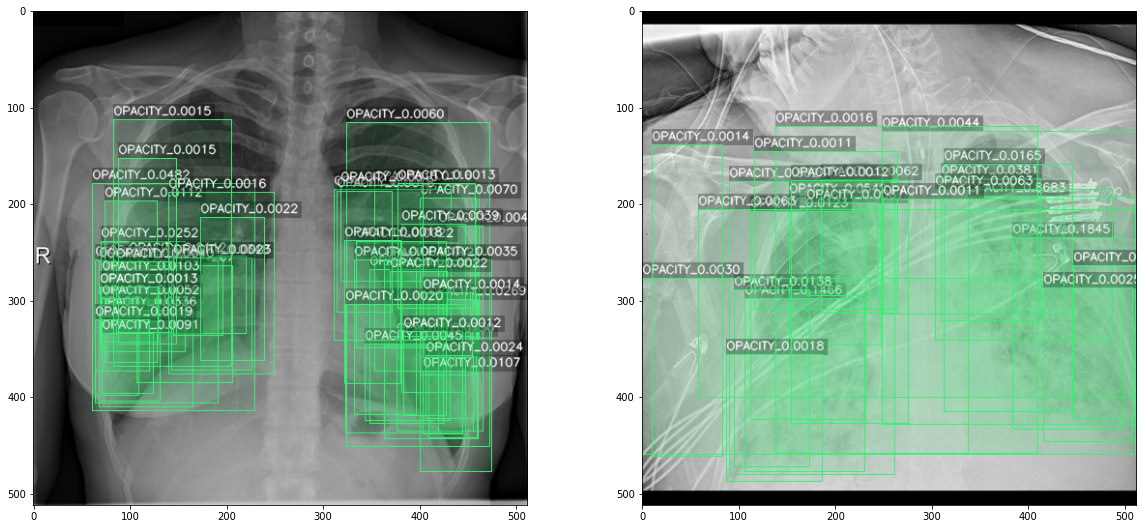

In [14]:
from ensemble_boxes import weighted_boxes_fusion, nms

viz_images = []
results = []
score_threshold = cfg.model.test_cfg.rcnn.score_thr

def format_pred(boxes: np.ndarray, scores: np.ndarray, labels: np.ndarray) -> str:
    pred_strings = []
    label_str = ['opacity']
    for label, score, bbox in zip(labels, scores, boxes):
        xmin, ymin, xmax, ymax = bbox.astype(np.int64)
        pred_strings.append(f"{label_str[int(label)]} {score:.16f} {xmin} {ymin} {xmax} {ymax}")
    return " ".join(pred_strings)

model.to(device)
model.eval()

viz_images = []

with torch.no_grad():
    for index, row in tqdm(image_df.iterrows(), total=image_df.shape[0]):
        original_H, original_W = (int(row.dim0), int(row.dim1))
        predictions = inference_detector(model, row.image_path)
        boxes, scores, labels = (list(), list(), list())

        for k, cls_result in enumerate(predictions):
#             print("cls_result", cls_result)
            if cls_result.size != 0:
                if len(labels)==0:
                    boxes = np.array(cls_result[:, :4])
                    scores = np.array(cls_result[:, 4])
                    labels = np.array([k]*len(cls_result[:, 4]))
                else:    
                    boxes = np.concatenate((boxes, np.array(cls_result[:, :4])))
                    scores = np.concatenate((scores, np.array(cls_result[:, 4])))
                    labels = np.concatenate((labels, [k]*len(cls_result[:, 4])))
                    
            if fast_sub:
                img_viz = cv2.imread(row.image_path)
                for box, label, score in zip(boxes, labels, scores):
                    color = label2color[int(label)]
                    img_viz = draw_bbox_small(img_viz, box.astype(np.int32), f'opacity_{score:.4f}', color)
                viz_images.append(img_viz)

        indexes = np.where(scores > score_threshold)
#         print(indexes)
        boxes = boxes[indexes]
        scores = scores[indexes]
        labels = labels[indexes]

        if len(labels) != 0:
            h_ratio = original_H/IMAGE_DIMS[0]
            w_ratio = original_W/IMAGE_DIMS[1]
            boxes[:, [0, 2]] *= w_ratio
            boxes[:, [1, 3]] *= h_ratio

            result = {
                "id": row.image_id,
                "PredictionString": format_pred(
                    boxes, scores, labels
                ),
            }

            results.append(result)
del model
gc.collect()

detection_df = pd.DataFrame(results, columns=['id', 'PredictionString'])

if fast_sub:
    display(detection_df.sample(2))
    # Plot sample images
    plot_imgs(viz_images, cmap=None)
    plt.savefig('viz_fig_siim.png', bbox_inches='tight')
    plt.show()

In [15]:
detection_df = detection_df.merge(image_df[['image_id', 'none']].rename({'image_id':'id'}, axis=1),
                                  on='id', how='left')

for i in range(detection_df.shape[0]):
    if detection_df.loc[i,'PredictionString'] != 'none 1 0 0 1 1':
        detection_df.loc[i,'PredictionString'] = detection_df.loc[i,'PredictionString'] + ' none ' + str(detection_df.loc[i,'none']) + ' 0 0 1 1'
detection_df = detection_df[['id', 'PredictionString']]

results_df = study_df[['study_id', 'PredictionString']].rename({'study_id':'id'}, axis=1)
results_df = results_df.append(detection_df[['id', 'PredictionString']])

/opt/conda/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [16]:
sub_df = pd.read_csv('/kaggle/input/siim-covid19-detection/sample_submission.csv')
sub_df['PredictionString'] = np.nan
sub_df = sub_df.set_index('id')
results_df = results_df.set_index('id')
sub_df.update(results_df)
sub_df = sub_df.reset_index()
sub_df = sub_df.fillna("none 1 0 0 1 1")
sub_df.to_csv('/kaggle/working/submission.csv', index=False)

if fast_sub:
    display(sub_df.head(2))

,id,PredictionString
0,00188a671292_study,none 1 0 0 1 1
1,004bd59708be_study,none 1 0 0 1 1


In [17]:
sub_df = pd.read_csv('/kaggle/input/siim-covid19-detection/sample_submission.csv')
sub_df['PredictionString'] = np.nan
# sub_df = sub_df.set_index('id')
sub_df.head(5)

/opt/conda/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,id,PredictionString
0,00188a671292_study,NaN
1,004bd59708be_study,NaN
2,00508faccd39_study,NaN
3,006486aa80b2_study,NaN
4,00655178fdfc_study,NaN


In [18]:
!rm -r /kaggle/working/mmdetection

/opt/conda/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<p style='text-align: center;'><span style="color: #000508; font-family: Segoe UI; font-size: 2.4em; font-weight: 300;">HAVE A GREAT DAY!</span></p>

<p style='text-align: center;'><span style="color: #000508; font-family: Segoe UI; font-size: 1.4em; font-weight: 300;">Let me know if you have any suggestions!</span></p>